# 0.0 Imports

In [1]:
import math
import numpy  as np
import pandas as pd
import random
import pickle
import requests
import warnings
import inflection
import seaborn as sns
import xgboost as xgb
import matplotlib.gridspec as gridspec

from scipy                 import stats  as ss
from boruta                import BorutaPy
from matplotlib            import pyplot as plt
from IPython.display       import Image
from IPython.core.display  import HTML


from sklearn.metrics       import mean_absolute_error, mean_squared_error
from sklearn.ensemble      import RandomForestRegressor
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder

warnings.filterwarnings( 'ignore' )

# 0.1 Helper Functions

In [2]:
# v de cramer
def cramer_v( x, y):
    cm = pd.crosstab(x, y).values
    
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    
    chi2corr = max(0, chi2 - (k-1) * (r-1) / (n-1))
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))

In [3]:
def mean_percentage_error( y, yhat):
    return np.mean((y - yhat) / y)

def mean_absolute_percentage_error( y, yhat):
    return np.mean(np.abs ((y - yhat) / y))

def ml_error( model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    
    return pd.DataFrame( {'Model Name': model_name,
                          'MAE': mae,
                          'MAPE': mape,
                          'RMSE': rmse}, index=[0])

In [4]:
def cross_validation(x_training, kfold, model_name, model, verbose=False):
    mae_list = []
    mape_list = []
    rmse_list = []

    for k in reversed( range(1, kfold+1)):
        if verbose:
            print('\nKFold Number: {}'.format(k))

        #data inicio e fim de validação
        validation_start_date = x_training['date'].max() - datetime.timedelta(days= k*4*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta(days= (k-1)*4*7)

        #filtragem do dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # dataset de treino e validação
        xtraining = training.drop(['date', 'sales'], axis=1)
        ytraining = training['sales']

        xvalidation = validation.drop(['date', 'sales'], axis=1)
        yvalidation = validation['sales']

        #modelo
        m = model.fit( xtraining, ytraining)

        #predição
        yhat = m.predict( xvalidation )

        #performance
        m_result = ml_error(model_name,np.expm1(yvalidation), np.expm1(yhat))

        #store performance of each kfold iteration
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])

    return pd.DataFrame({'Model Name': model_name,
                         'MAE CV': np.round(np.mean(mae_list), 2).astype(str) + ' +/- ' + np.round(np.std(mae_list), 2).astype(str),
                         'MAPE CV': np.round(np.mean(mape_list), 2).astype(str) + ' +/- ' + np.round(np.std(mape_list), 2).astype(str),
                         'RMSE CV': np.round(np.mean(rmse_list), 2).astype(str) + ' +/- ' + np.round(np.std(rmse_list), 2).astype(str)}, index=[0])


In [5]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25,12]
    plt.rcParams['font.size'] = 24
    
    display( HTML ('<style..container {width:100% ! important;}</style>'))
    pd.options.display.max_columns= None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    
    sns.set()

jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


# 0.2 Loading data

In [6]:
df_sales_raw = pd.read_csv('../data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('../data/store.csv', low_memory=False)

#merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

In [7]:
df_raw.sample(5)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
294899,659,4,2014-10-30,4826,688,1,0,0,1,d,a,1590.0,3.0,2012.0,0,NaN,NaN,NaN
943693,74,4,2013-03-07,6702,928,1,1,0,0,a,a,330.0,NaN,NaN,0,NaN,NaN,NaN
336872,533,1,2014-09-15,13430,1294,1,1,0,0,a,c,5950.0,NaN,NaN,0,NaN,NaN,NaN
335479,1101,3,2014-09-17,10291,1001,1,1,0,0,d,c,4060.0,9.0,2012.0,0,NaN,NaN,NaN
850389,430,4,2013-05-30,0,0,0,1,a,1,d,c,12870.0,10.0,2008.0,0,NaN,NaN,NaN


# 1.0 Data description

In [8]:
df1 = df_raw.copy()

# 1.1 Rename Columns

In [9]:
df_raw.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [10]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday',
            'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear',
            'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore( x )

cols_new = list(map(snakecase, cols_old))

#apply rename
df1.columns = cols_new

In [11]:
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

# 1.2 Data dimensions

In [12]:
print('Número de linhas: {}'.format(df1.shape[0]))
print('Número de colunas: {}'.format(df1.shape[1]))

Número de linhas: 1017209
Número de colunas: 18


# 1.3 Data types

In [13]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [14]:
df1['date'] = pd.to_datetime(df1['date'])

# 1.4 Check NA

In [15]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

# 1.5 Fillout NA

In [16]:
#competition_distance
#substitui os NA e matém os valores existentes nas demais 
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

#competition_open_since_month
df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

#competition_open_since_year
df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)
                      
#promo2_since_week
df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

#promo2_since_year
df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

#promo_interval
month_map = {1:'Jan', 2:'Fev', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}
df1['promo_interval'].fillna(0, inplace = True)
df1['month_map'] = df1['date'].dt.month.map(month_map)
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis = 1)

In [17]:
df1.sample(5).T

,453726,929916,443926,34426,78222
store,707,792,942,977,173
day_of_week,3,3,5,3,5
date,2014-05-21 00:00:00,2013-03-20 00:00:00,2014-05-30 00:00:00,2015-07-01 00:00:00,2015-05-22 00:00:00
sales,7954,8055,6628,4264,7811
customers,869,716,559,462,972
open,1,1,1,1,1
promo,1,1,0,1,1
state_holiday,0,0,0,0,0
school_holiday,0,0,0,0,0
store_type,a,d,d,a,a


# 1.6 Change Types

In [18]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

In [19]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int32
competition_open_since_year              int32
promo2                                   int64
promo2_since_week                        int32
promo2_since_year                        int32
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

# 1.7 Descriptive Statistical

In [20]:
num_attributes = df1.select_dtypes(include =['int64', 'float64', 'int32'])
cat_attributes = df1.select_dtypes(exclude = ['int64', 'float64', 'int32', 'datetime64[ns]'])

# 1.7.1 Numerical attributes

In [21]:
# Tendencia Central - Média e Mediana
ct1 = pd.DataFrame( num_attributes.apply( np.mean) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median) ).T

# Dispersão - Desvio padrão, min, max, range (valor entre o min e o max), skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std) ).T
d2 = pd.DataFrame( num_attributes.apply( min )).T
d3 = pd.DataFrame( num_attributes.apply( max )).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() )).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() )).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() )).T

#Concatenar métricas
mt = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
mt.columns = (['attributes','min','max','range','mean','median','std','skew','kurtosis'])

mt

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


# 1.7.2 Categorical attributes

In [22]:
cat_attributes.apply( lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

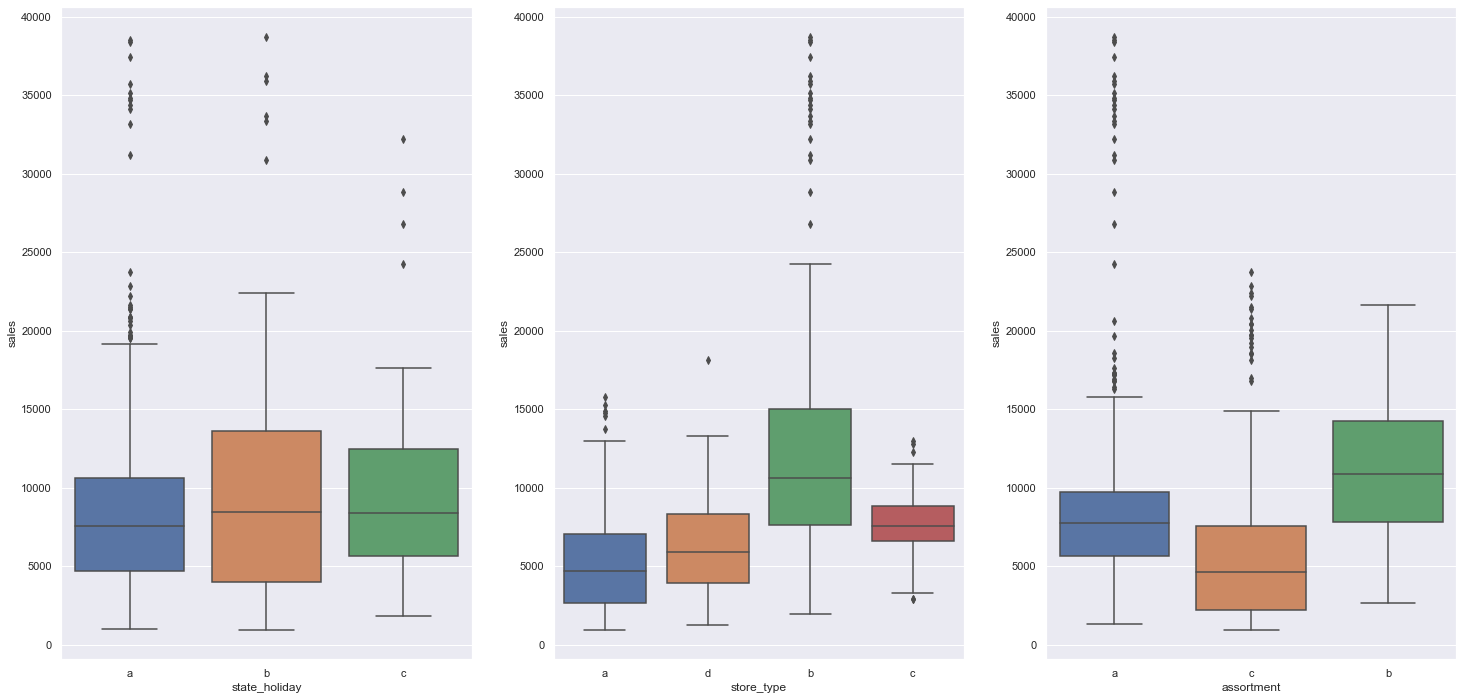

In [23]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot(1, 3, 1)
sns.boxplot(x='state_holiday', y='sales', data=aux1)

plt.subplot(1, 3, 2)
sns.boxplot(x='store_type', y='sales', data=aux1)

plt.subplot(1, 3, 3)
sns.boxplot(x='assortment', y='sales', data=aux1)

# 2.0 Feature Engennering

## 2.0.1 Mind Map

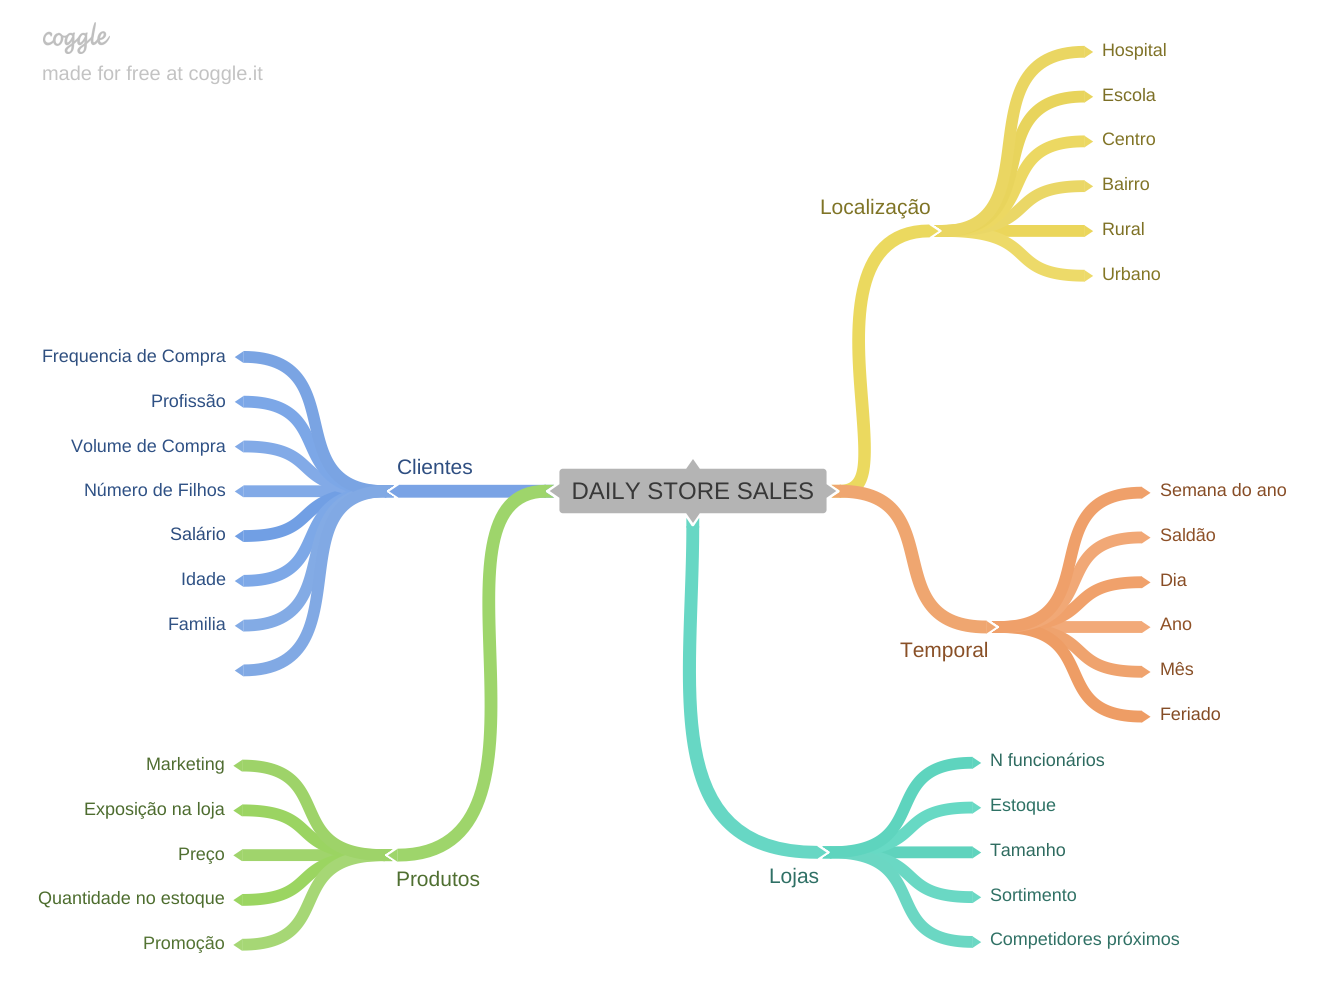

In [24]:
Image('../img/mind_map.png')

## 2.1 Creating hypotheses

### 2.1.1 Store hypothesis

### 2.1.2 Product hypothesis

### 2.1.3 Temporal hypothesis

# 2.2 Final list of hypotheses

# 2.3 Feature Engineering

In [25]:
df2 = df1.copy()

In [26]:
# variáveis que vão ser derivadas da origintal
# ano
df2['year'] = df2['date'].dt.year

# mês
df2['month'] = df2['date'].dt.month

# dia
df2['day'] = df2['date'].dt.day

# semana do ano
df2['week_of_year'] = df2['date'].dt.isocalendar().week

# semana do ano
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# ano competidor desde
df2['competition_since'] = df2.apply( lambda x: datetime.datetime (year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis =1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since']) /30).apply(lambda x: x.days).astype(int)

# ano promoção desde
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta (days=7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since']) / 7).apply( lambda x: x.days).astype(int)

# sortimento
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b'else 'extended')

# feriado estadual
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b'else 'christmas' if x == 'c'else 'regular_day')

In [27]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0 Variable filtering

In [28]:
df3 = df2.copy()

df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 3.1 Line filtering

In [29]:
df3 = df3[(df3['open'] != 0) &  (df3['sales'] > 0)]

## 3.2 Selection of columns

In [30]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']

df3 = df3.drop(cols_drop, axis=1)

df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0 Exploratory data analysis

In [31]:
df4 = df3.copy()

df4.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 4.1 Univariate analysis

### 4.1.1 Response variable

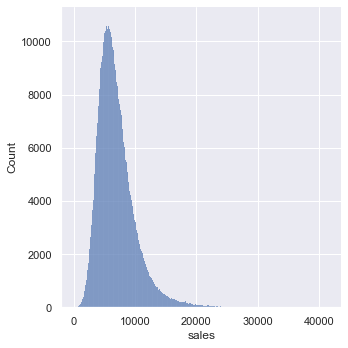

In [32]:
sns.displot(df4['sales'])

### 4.1.2 Numerical variable

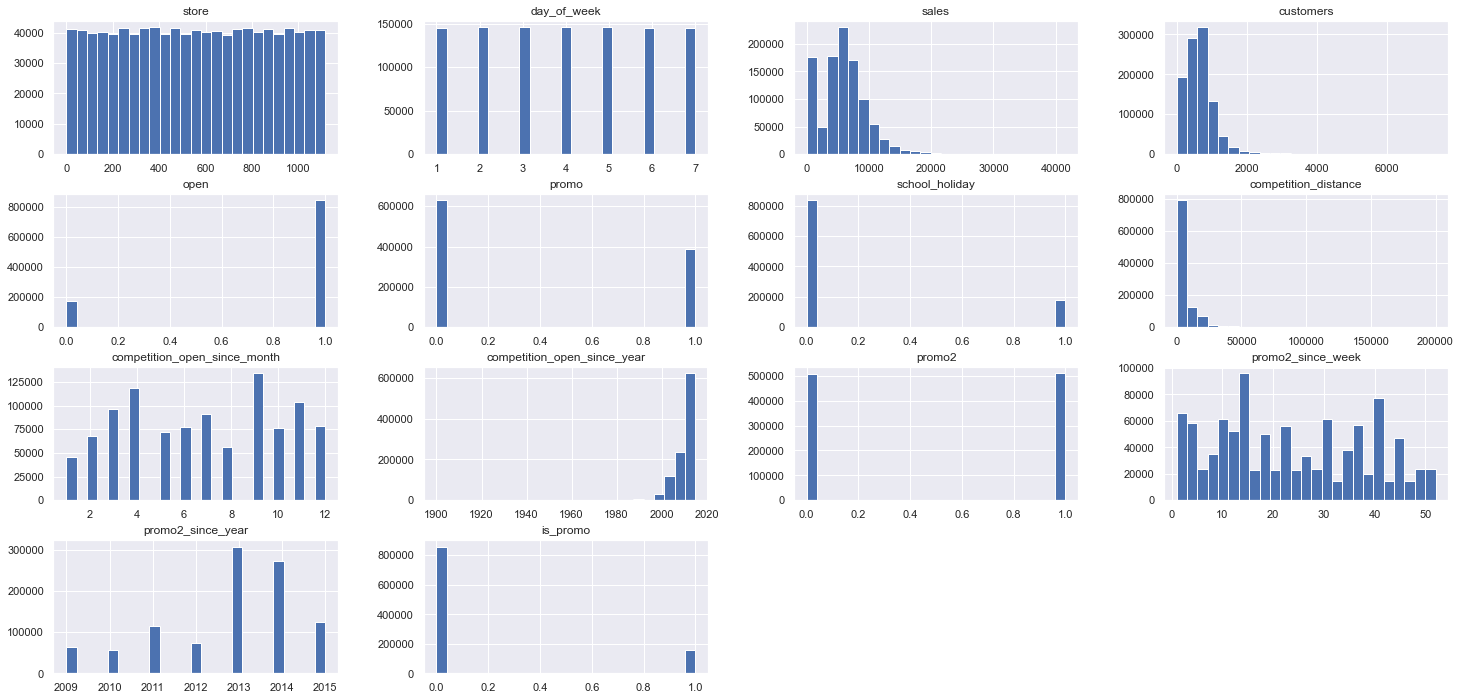

In [33]:
num_attributes.hist(bins=25);

### 4.1.3 Categorical variable

In [34]:
df4['state_holiday'].drop_duplicates()

0            regular_day
63559     public_holiday
129424    easter_holiday
241126         christmas
Name: state_holiday, dtype: object

In [35]:
df4['store_type'].drop_duplicates()

0     c
1     a
12    d
84    b
Name: store_type, dtype: object

In [36]:
df4['assortment'].drop_duplicates()

0         basic
3      extended
258       extra
Name: assortment, dtype: object

<AxesSubplot:xlabel='sales', ylabel='Density'>

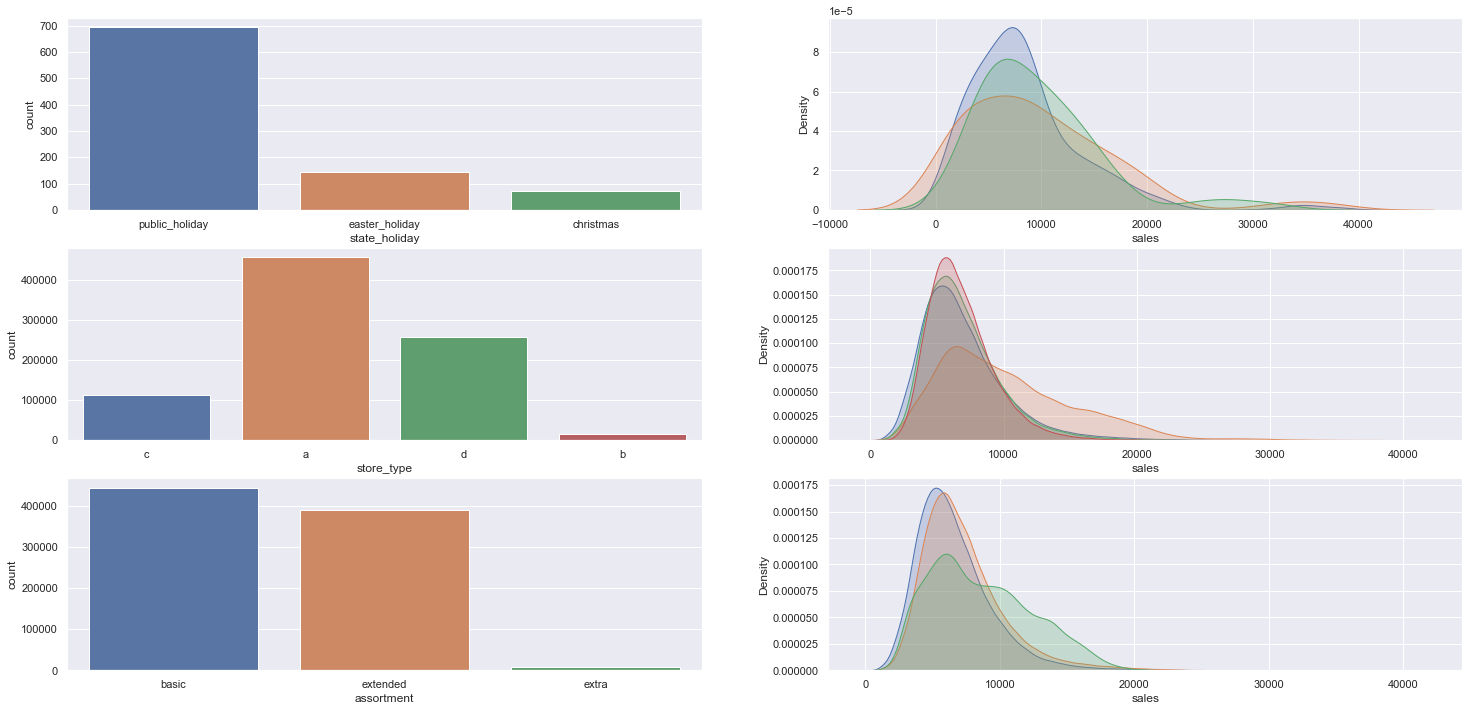

In [37]:
#state holiday
plt.subplot(3,2, 1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot( a['state_holiday'] )

plt.subplot(3,2, 2)
sns.kdeplot( df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True)
sns.kdeplot( df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True)
sns.kdeplot( df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True)

#store_type
plt.subplot(3,2, 3)
sns.countplot( df4['store_type'] )

plt.subplot(3,2, 4)
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'], label='a', shade=True)
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'], label='b', shade=True)
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'], label='c', shade=True)
sns.kdeplot( df4[df4['store_type'] == 'd']['sales'], label='d', shade=True)

# assortment
plt.subplot(3,2, 5)
sns.countplot( df4['assortment'] )

plt.subplot(3,2, 6)
sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True)
sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True)
sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True)

## 4.2 Análise bivariada

### 1- Lojas com maior sortimentos deveriam vender mais.
**Falso:** Lojas com maior sortimento (extra) vendem menos.

<AxesSubplot:xlabel='year_week'>

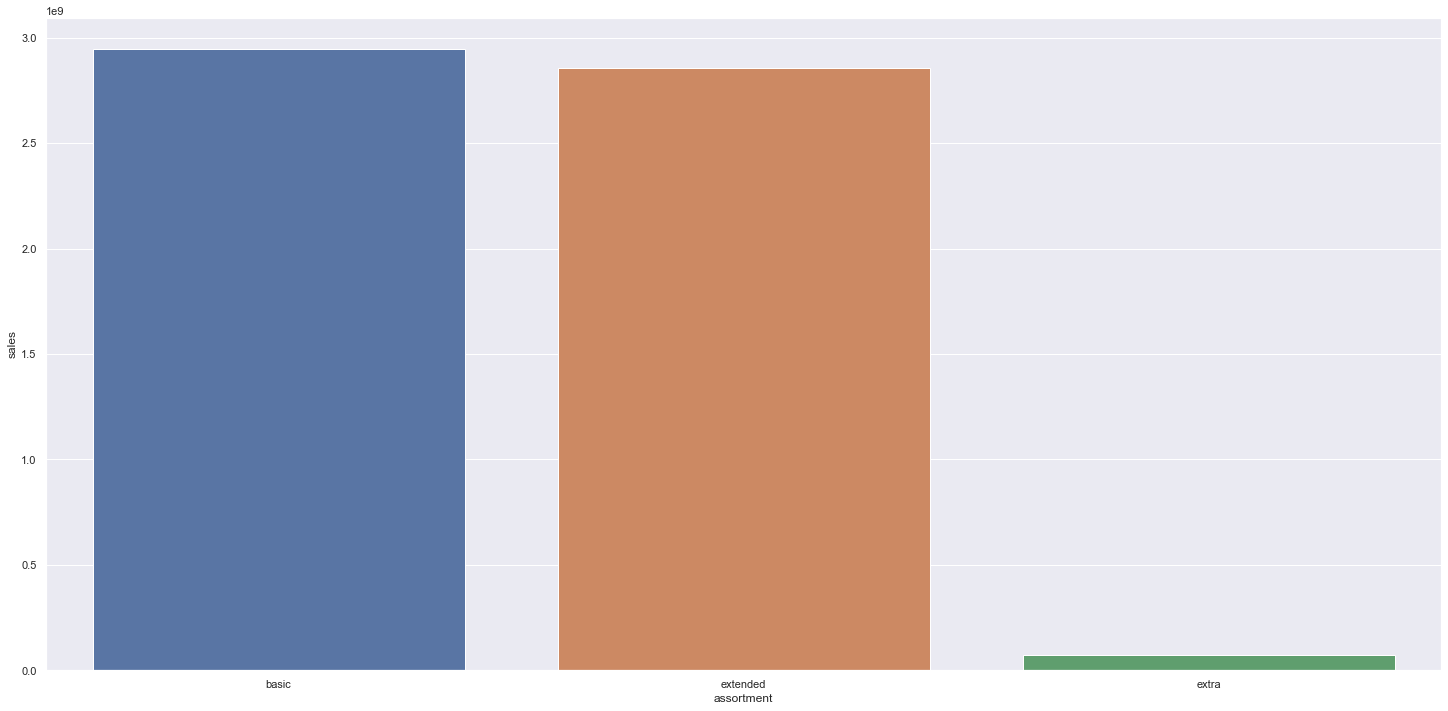

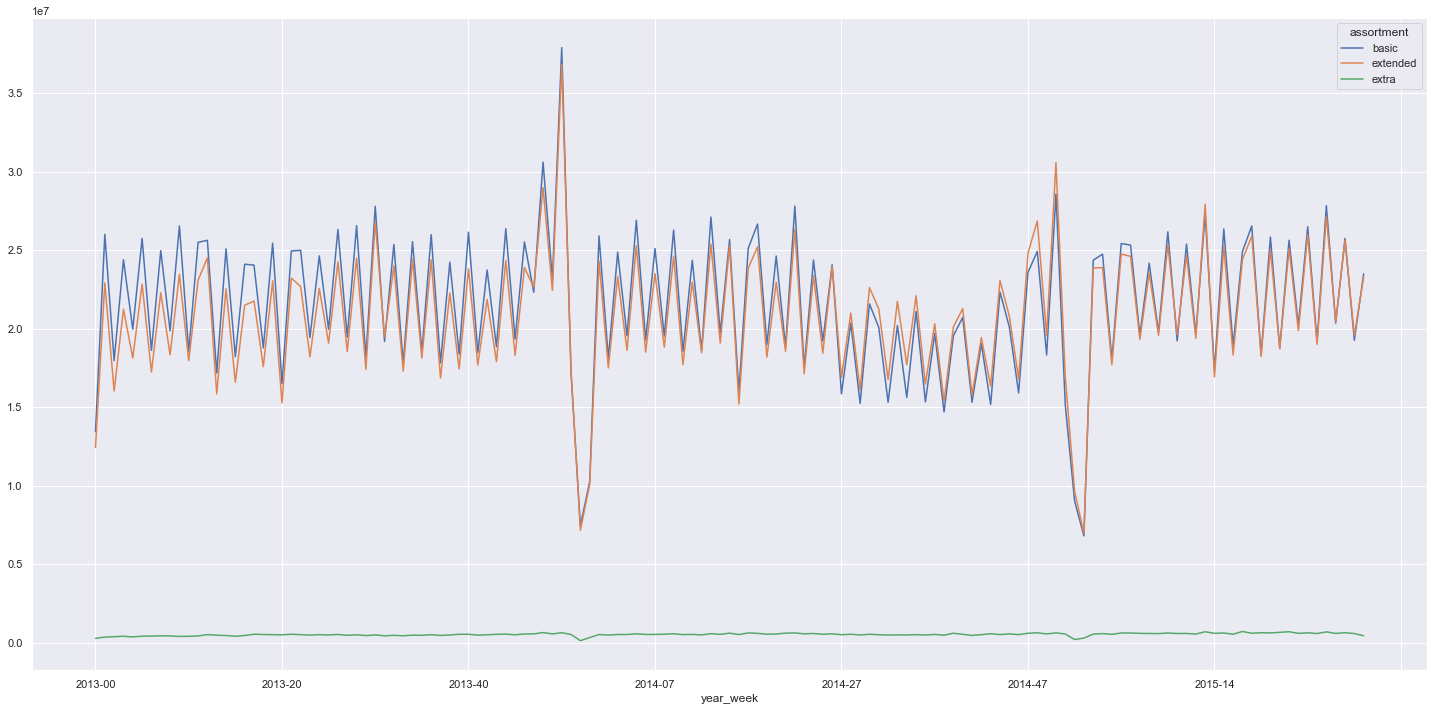

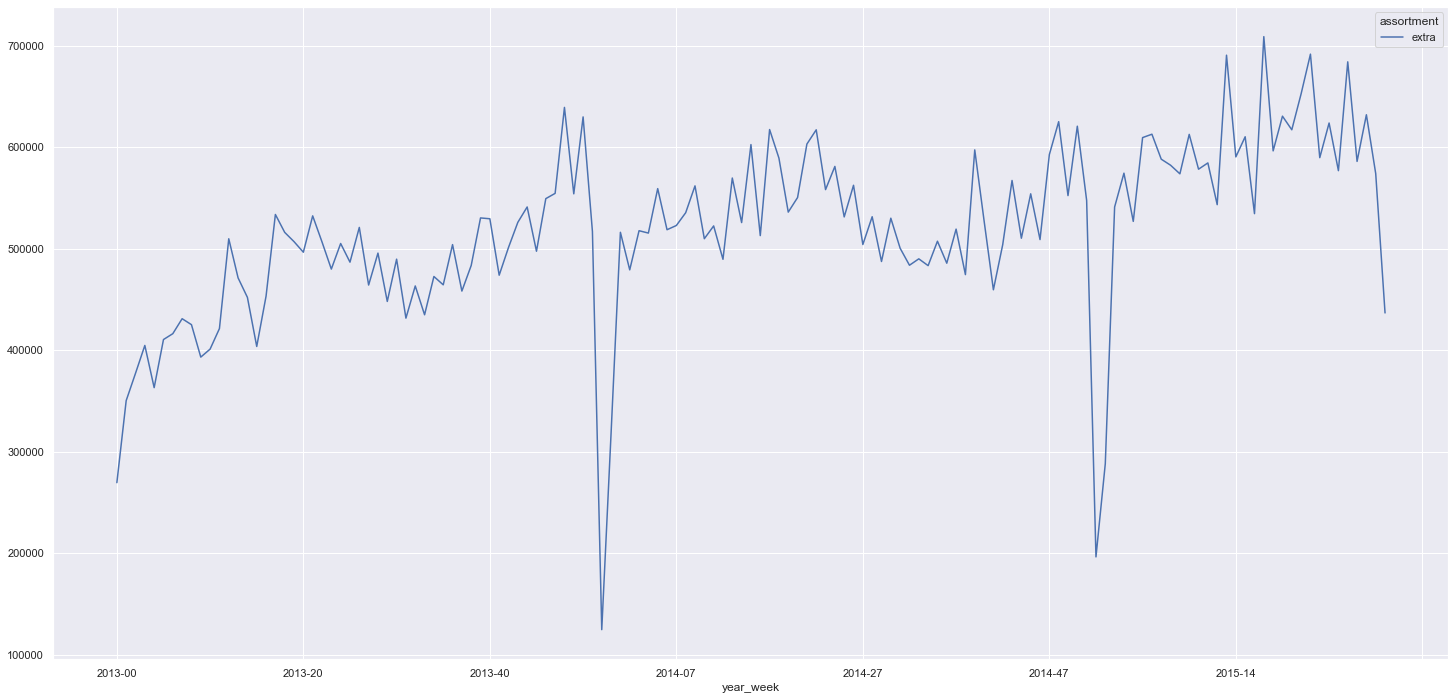

In [38]:
aux1 = df4[['assortment','sales']].groupby('assortment').sum().reset_index()
sns.barplot( x='assortment', y='sales', data=aux1);


aux2 = df4[['year_week','assortment','sales']].groupby(['year_week','assortment']).sum().reset_index()
aux2.pivot(index='year_week', columns='assortment', values='sales').plot()

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index='year_week', columns='assortment', values='sales').plot()

### 2- Lojas com competidores mais próximos deveriam vender menos.
**Falso:** Na realidade lojas com competidores mais próximos, vendem mais e não menos.

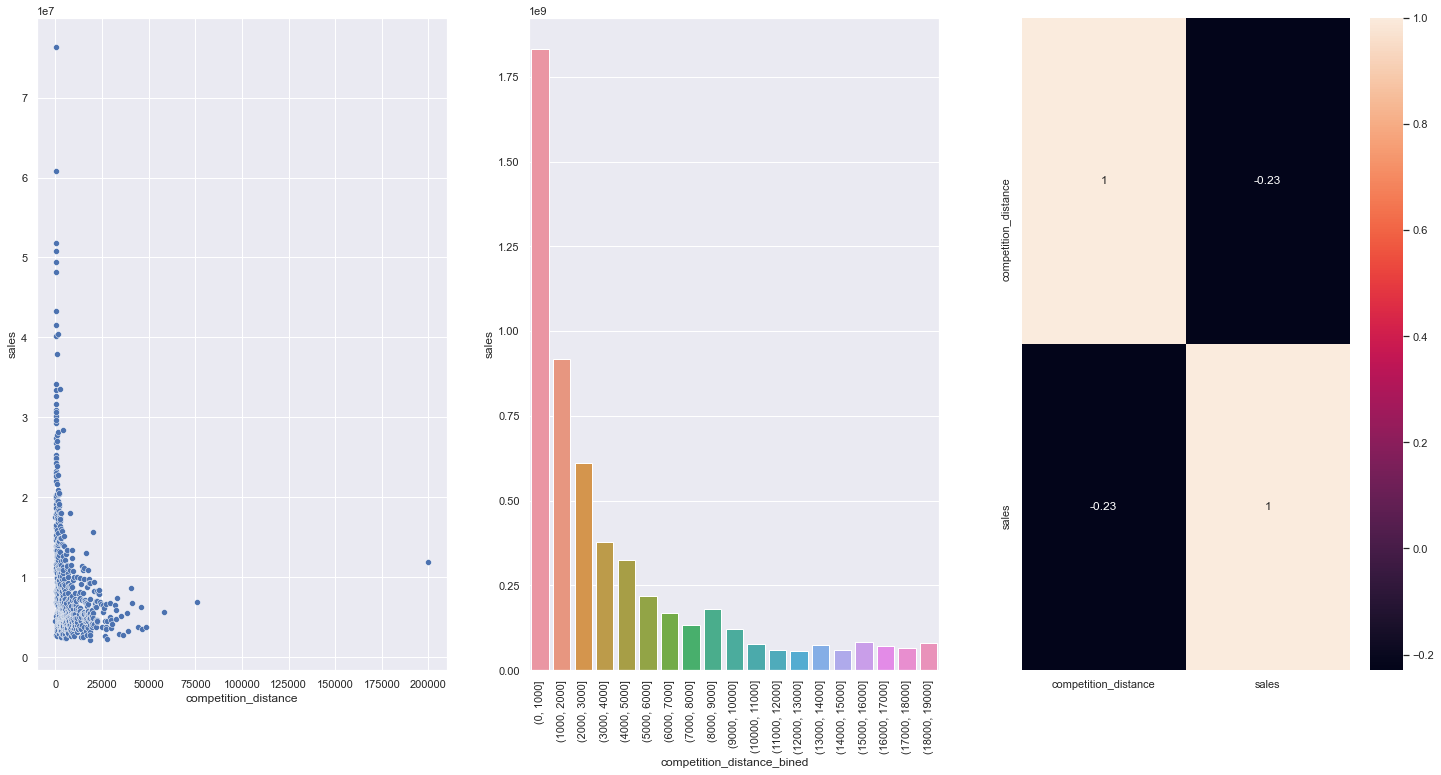

In [39]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

plt.subplot( 1, 3, 1)
sns.scatterplot (x ='competition_distance', y='sales', data=aux1);

plt.subplot (1, 3, 2)
bins = list( np.arange(0, 20000, 1000) )
aux1['competition_distance_bined'] = pd.cut( aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_bined', 'sales']].groupby('competition_distance_bined').sum().reset_index()
sns.barplot(x='competition_distance_bined', y='sales', data=aux2);
plt.xticks(rotation=90);

plt.subplot (1, 3, 3)
sns.heatmap(aux1.corr( method='pearson'), annot=True );

### 3- Lojas com competidores à mais tempo deveriam vender mais.
**Falso:** Lojas com competidores a mais tempo vendem menos;

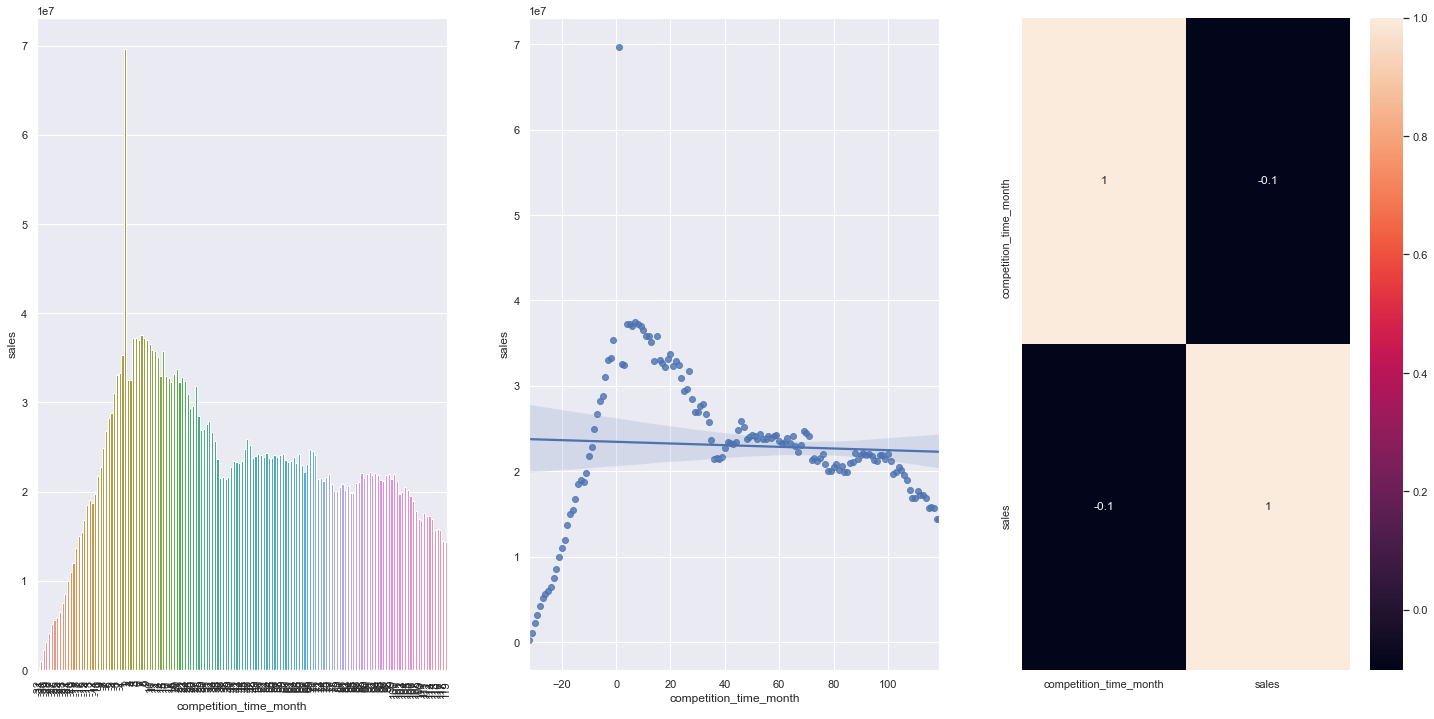

In [40]:
plt.subplot(1, 3, 1)
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]
sns.barplot(x='competition_time_month', y='sales', data=aux2)
plt.xticks( rotation = 90);

plt.subplot(1, 3, 2)
sns.regplot(x='competition_time_month', y='sales', data=aux2);

plt.subplot(1, 3, 3)
sns.heatmap( aux1.corr( method='pearson'), annot=True);

### 4- Lojas com promoções ativas por mais tempo deveriam vender mais.
**Falso:** Promoções ativas por mais tempo vendem regularmente durante um periodo e depois vai caindo;

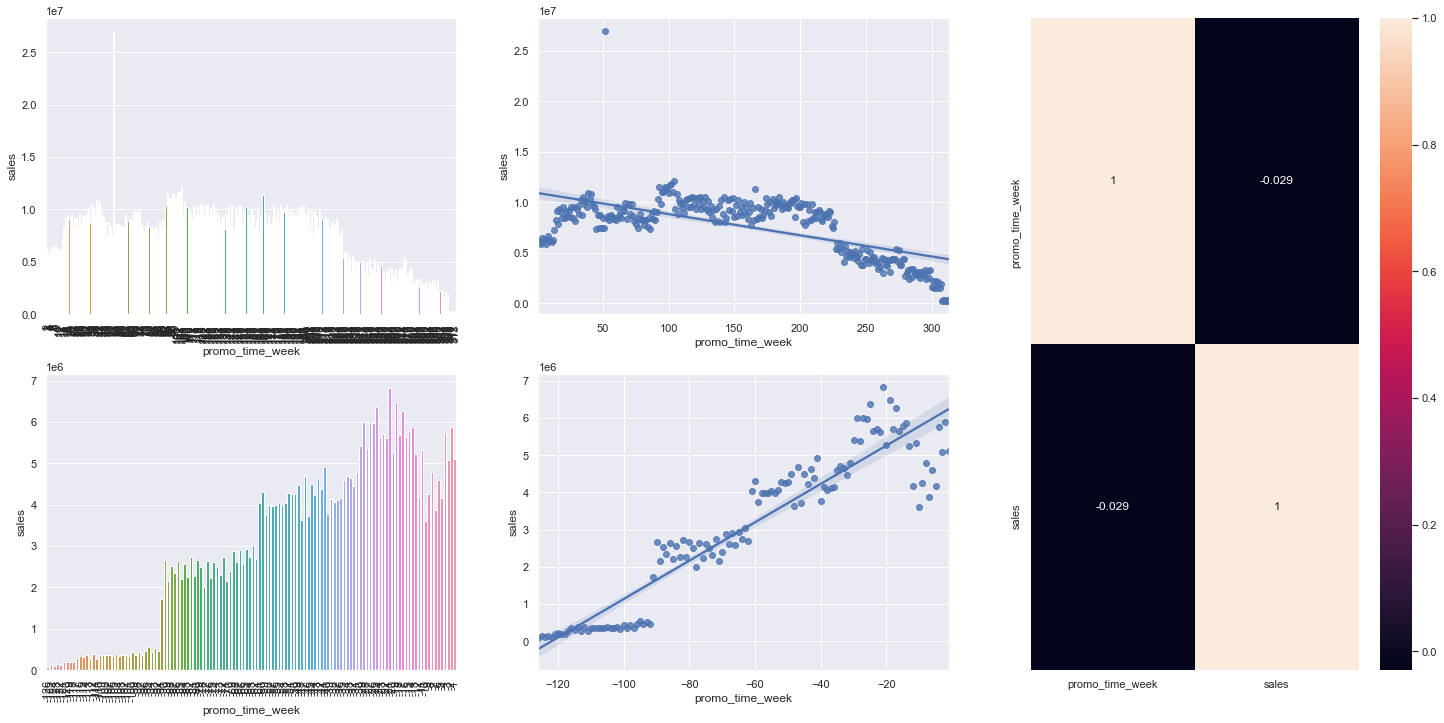

In [41]:
aux1 = df4[['promo_time_week','sales']].groupby('promo_time_week').sum().reset_index()

grid = gridspec.GridSpec(2,3)

plt.subplot(grid[0,0])
aux2 = aux1[aux1['promo_time_week'] > 0] #periodo extendido de promoção
sns.barplot( x='promo_time_week', y='sales', data=aux2);
plt.xticks(rotation = 90);

plt.subplot(grid[0,1])
sns.regplot( x='promo_time_week', y='sales', data=aux2);

plt.subplot(grid[1,0])
aux3 = aux1[aux1['promo_time_week'] < 0] #periodo regular de promoção
sns.barplot( x='promo_time_week', y='sales', data=aux3);
plt.xticks(rotation = 90);

plt.subplot(grid[1,1])
sns.regplot( x='promo_time_week', y='sales', data=aux3);

plt.subplot(grid[:,2])
sns.heatmap( aux1.corr( method='pearson'), annot=True);

### 5- Lojas com mais dias de promoção deveriam vender mais.
**Validação no próximo ciclo**

### 6- Lojas com mais promoções consecutivas deveriam vender mais.
**Falso:** Lojas com mais promoções consecutivas vendem menos;

In [42]:
df4[['promo','promo2','sales']].groupby(['promo', 'promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


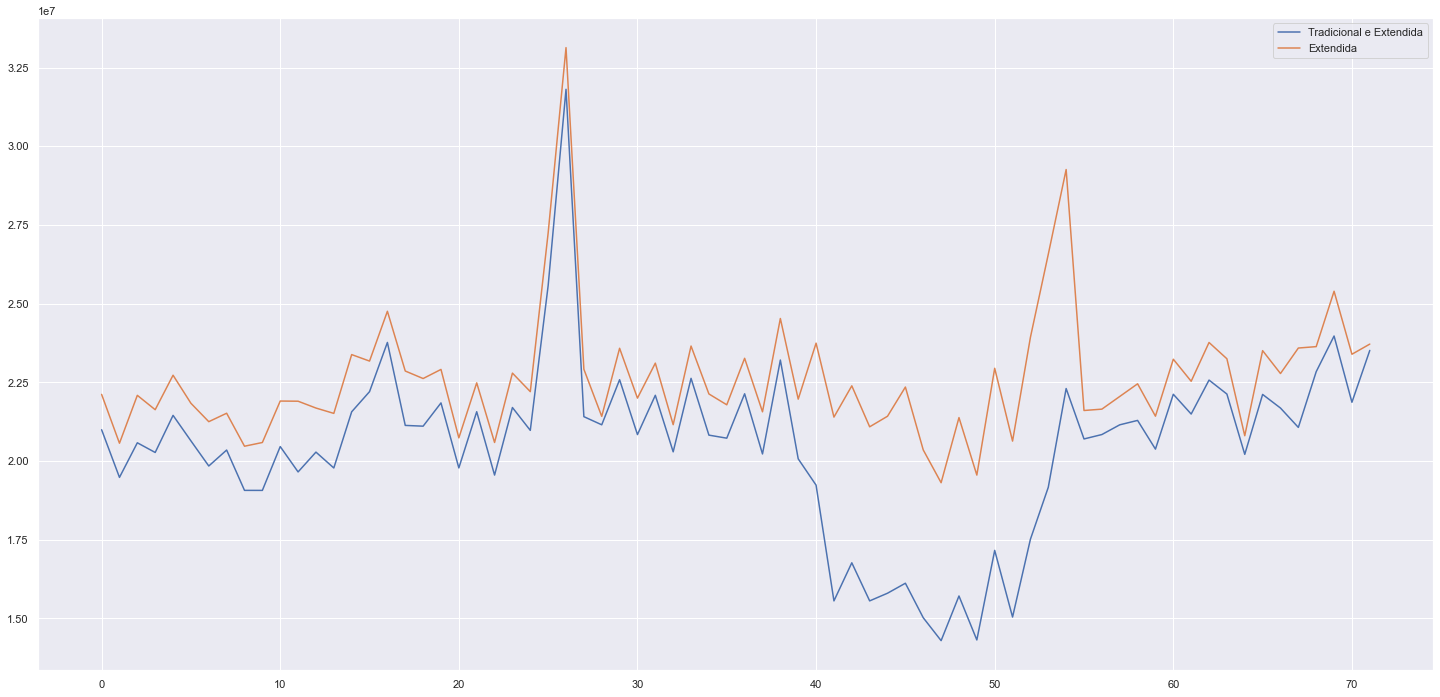

In [43]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax)

ax.legend(labels=['Tradicional e Extendida','Extendida']);

### 7- Lojas abertas durante o feriado de natal deveriam vender mais.
**Falso:** Lojas abertas durante o feriado do natal, vendem menos;

<AxesSubplot:xlabel='year', ylabel='sales'>

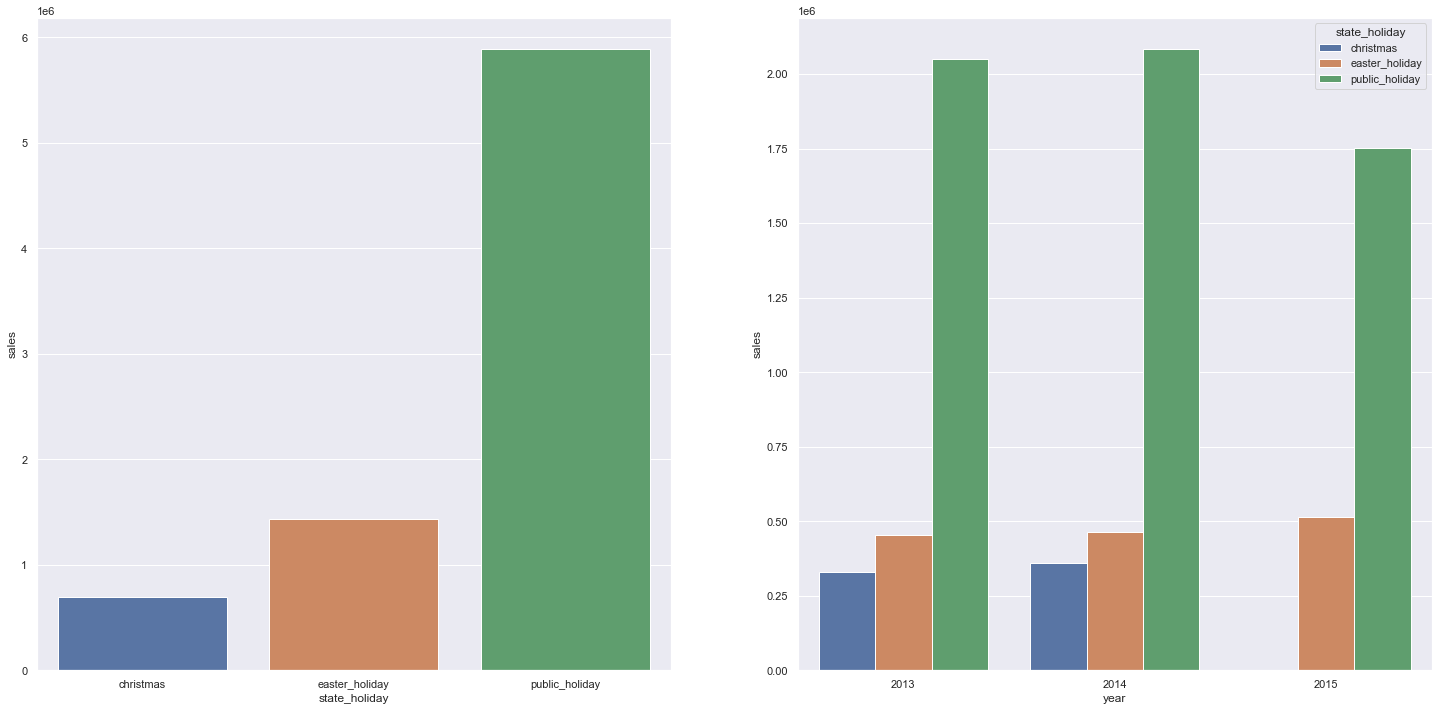

In [44]:
aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot(1,2,1)
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x = 'state_holiday', y='sales', data=aux1)

plt.subplot(1,2,2)
aux2 = aux[['year','state_holiday','sales']].groupby(['year', 'state_holiday']).sum().reset_index()
sns.barplot(x = 'year', y='sales', hue='state_holiday', data=aux2)

### 8- Lojas deveriam vender mais ao longo dos anos.
**Falso:** Lojas vendem menos ao longo dos anos;

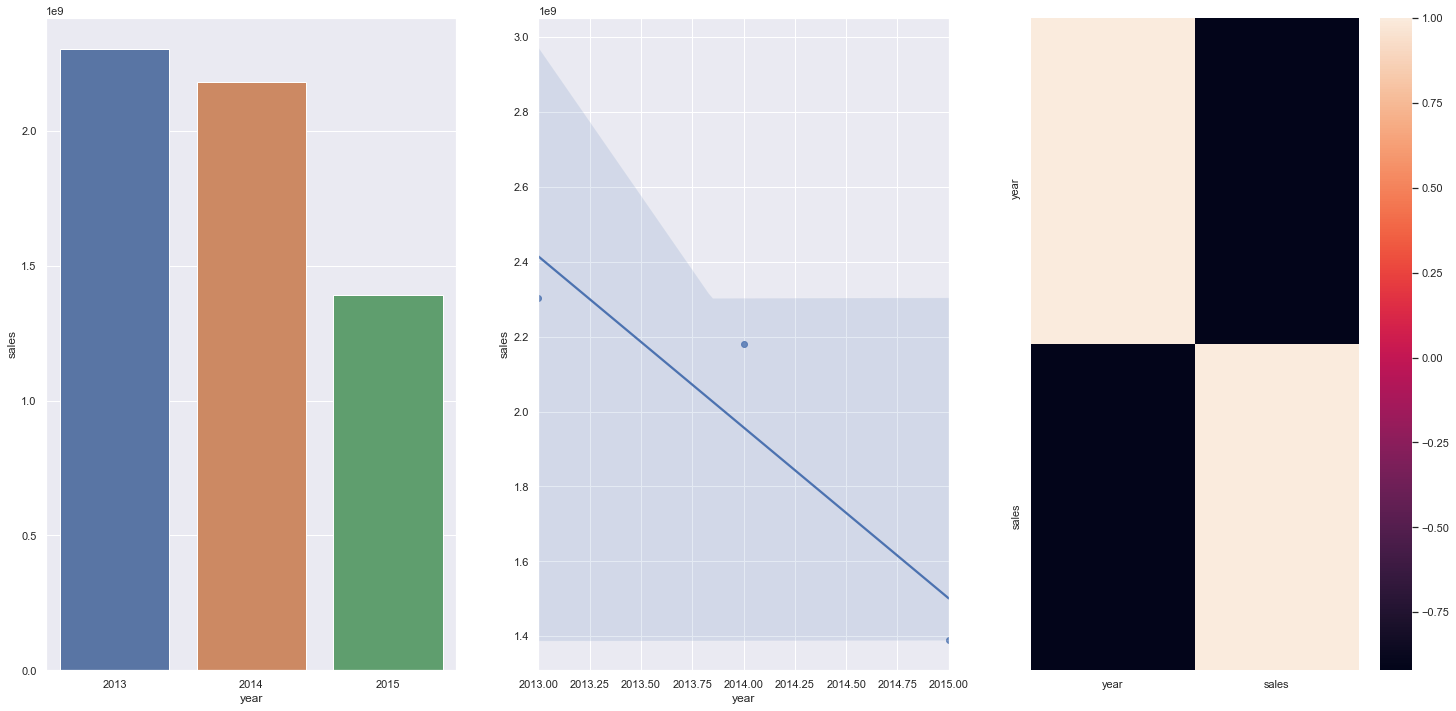

In [45]:
aux1 = df4[['year','sales']].groupby('year').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x = 'year', y='sales', data=aux1)

plt.subplot(1,3,2)
sns.regplot(x = 'year', y='sales', data=aux1)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'));

### 9- Lojas deveriam vender mais no segundo semestre do ano.
**Falso:** Lojas vendem menos no segundo semestre do ano;

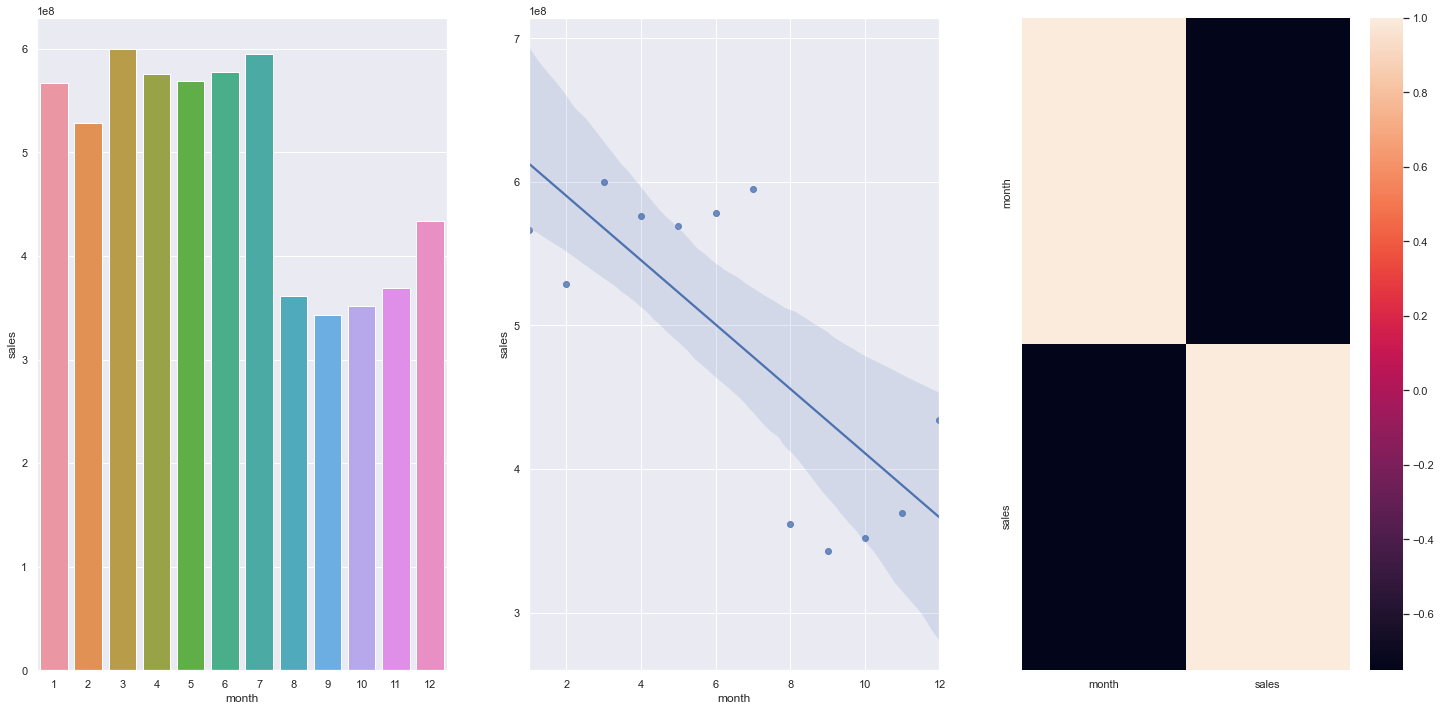

In [46]:
aux1 = df4[['month','sales']].groupby('month').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x = 'month', y='sales', data=aux1)

plt.subplot(1,3,2)
sns.regplot(x = 'month', y='sales', data=aux1)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'));

### 10- Lojas deveriam vender mais depois do dia 10 de cada mês.
**Verdadeiro:** Lojas vendem mais depois do dia 10 de cada mês;

<AxesSubplot:xlabel='before_after', ylabel='sales'>

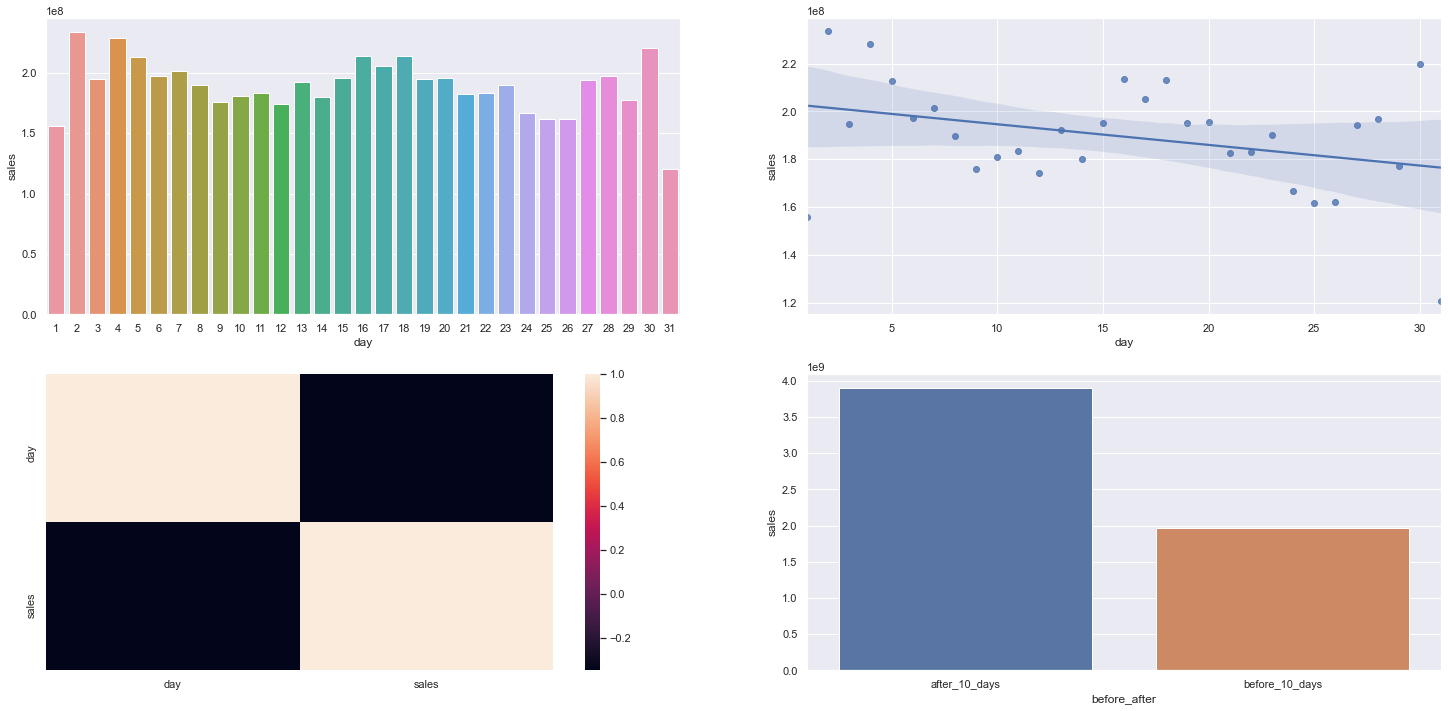

In [47]:
aux1 = df4[['day','sales']].groupby('day').sum().reset_index()

plt.subplot(2,2,1)
sns.barplot(x = 'day', y='sales', data=aux1)

plt.subplot(2,2,2)
sns.regplot(x = 'day', y='sales', data=aux1)

plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method='pearson'));

aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_days' if x<=10 else 'after_10_days')
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()

plt.subplot(2,2,4)
sns.barplot(x = 'before_after', y='sales', data=aux2)


### 11- Lojas deveriam vender menos aos finais de semana.
**Verdadeiro:** Lojas vendem menos nos finais de semana;

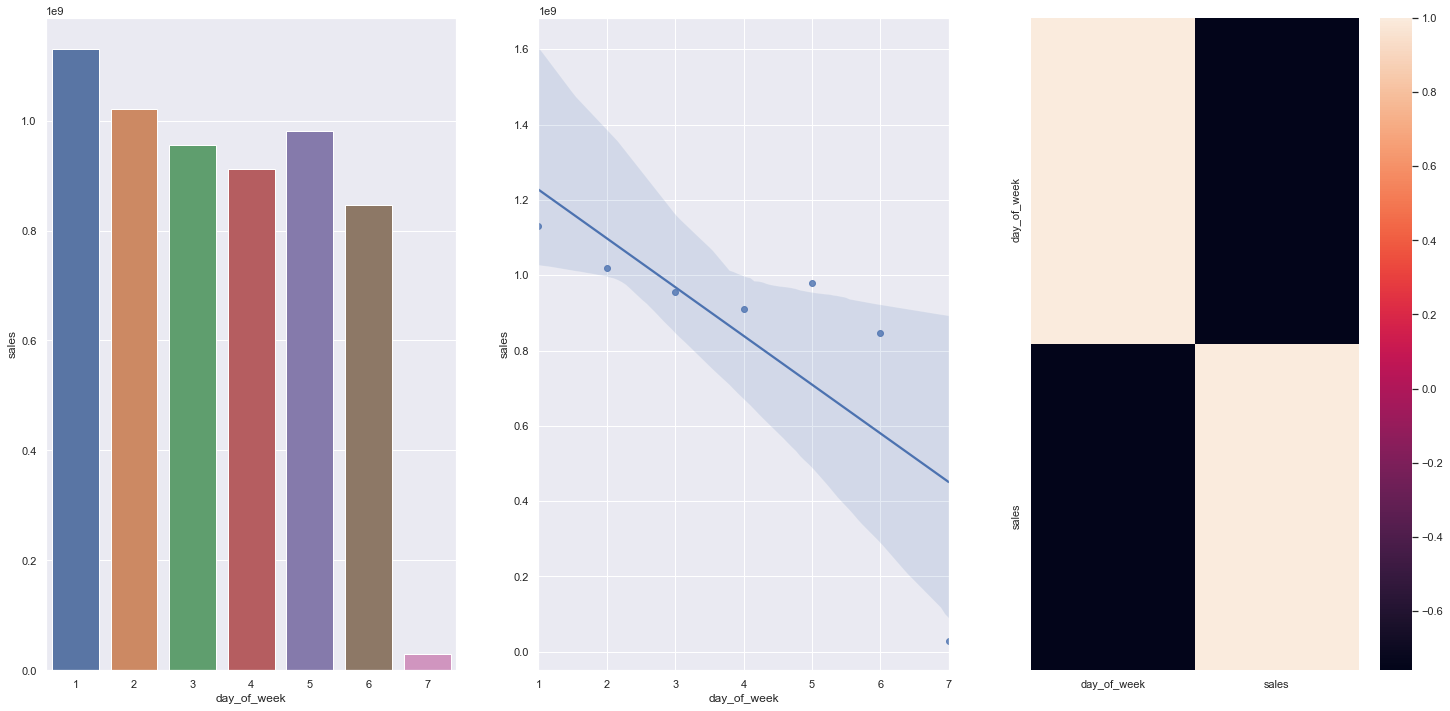

In [48]:
aux1 = df4[['day_of_week','sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x = 'day_of_week', y='sales', data=aux1)

plt.subplot(1,3,2)
sns.regplot(x = 'day_of_week', y='sales', data=aux1)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'));

### 12- Lojas deveriam vender menos durante os feriados escolares.
**Verdadeiro:** Lojas vendem menos durante os feriados escolares, exceto os meses de julho e agosto.

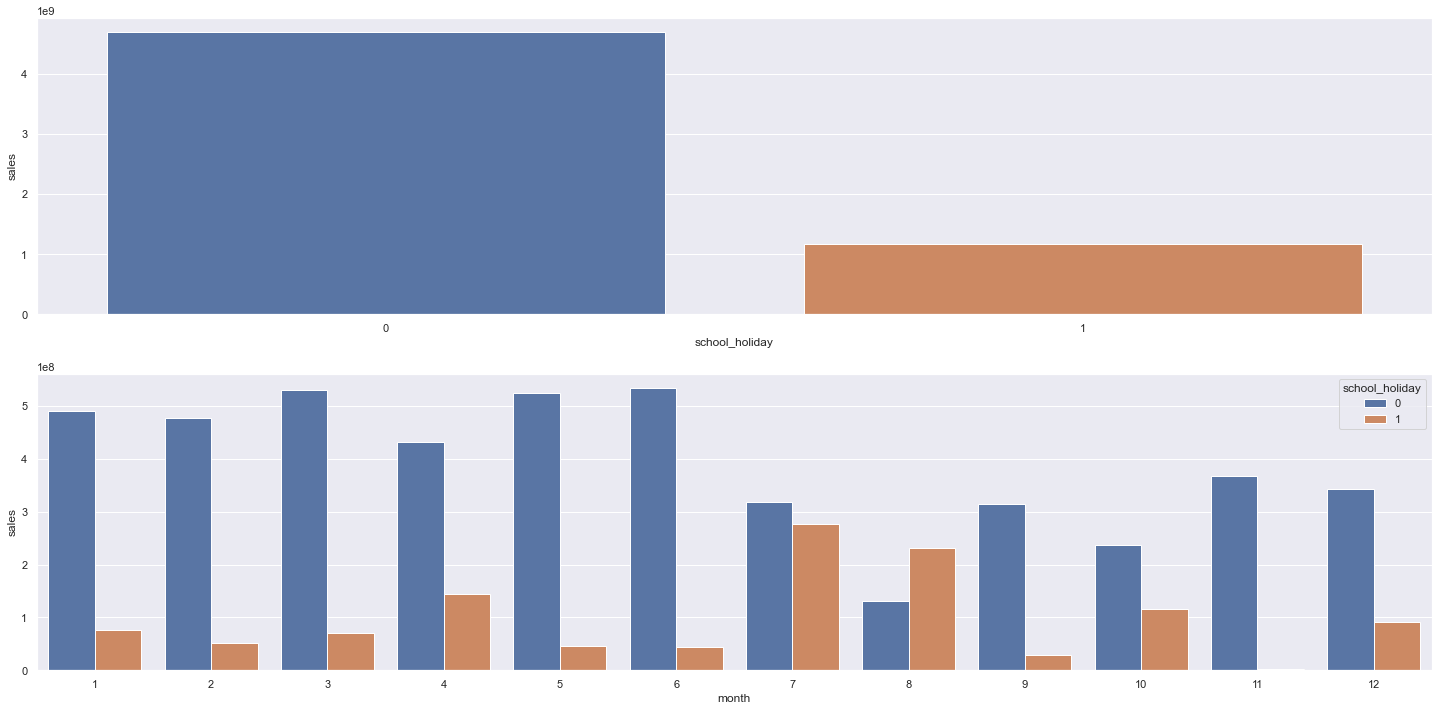

In [49]:
aux1 = df4[['school_holiday','sales']].groupby('school_holiday').sum().reset_index()

plt.subplot(2,1,1)
sns.barplot(x ='school_holiday', y='sales', data=aux1);

aux2 = df4[['month','school_holiday','sales']].groupby(['month','school_holiday']).sum().reset_index()

plt.subplot(2,1,2)
sns.barplot(x ='month', y='sales', hue='school_holiday', data=aux2);

# 4.3 Multivariate analysis

## 4.3.1 Numeric attributes

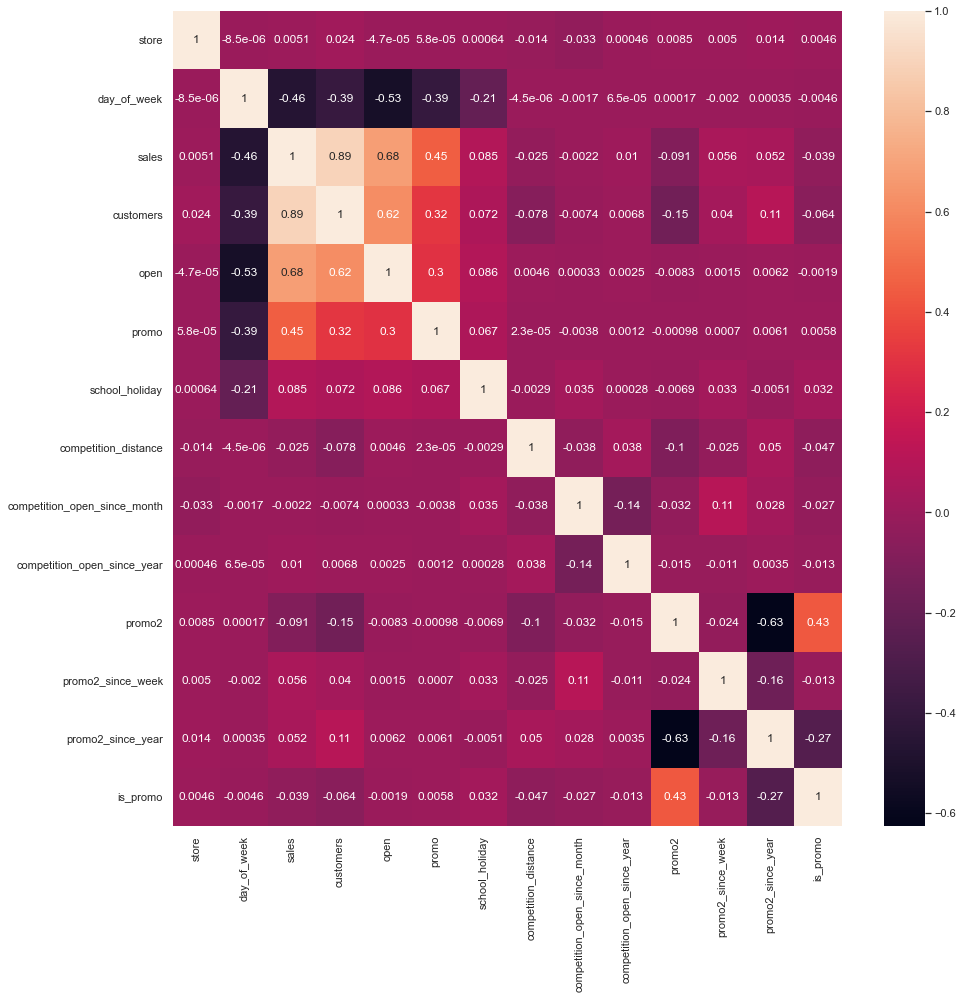

In [50]:
plt.rcParams['figure.figsize']=(15,15)
correlation = num_attributes.corr(method='pearson')
sns.heatmap( correlation, annot=True);

### 4.3.2 Categorical attributes

<AxesSubplot:>

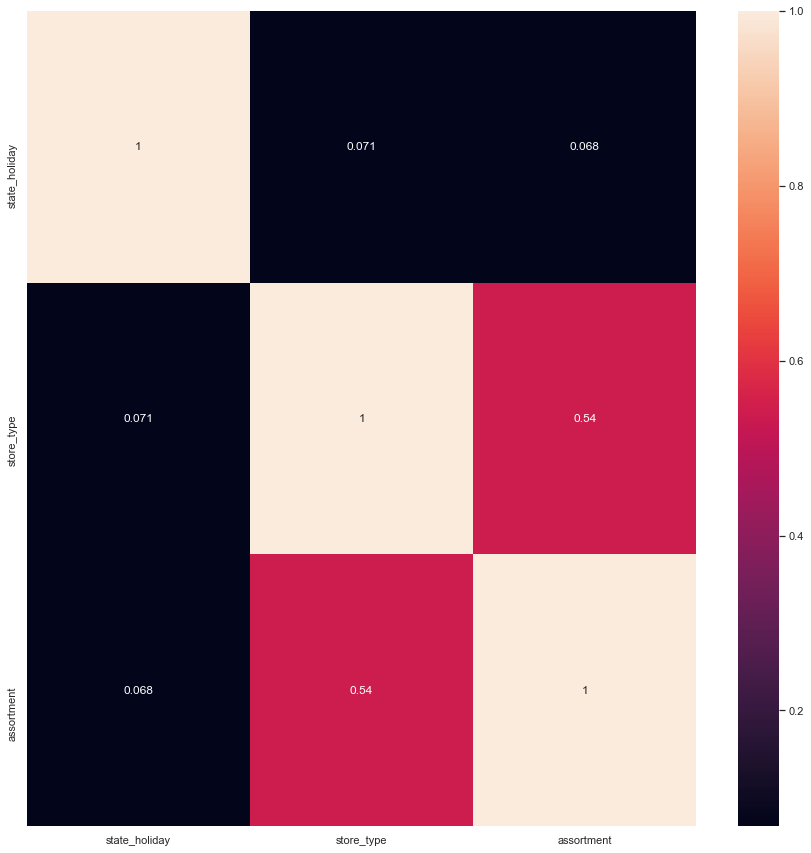

In [51]:
#Somente dados categóricos
a = df4.select_dtypes(include='object')

# calcula v cramer
a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])

# Datasset final
d = pd.DataFrame({'state_holiday': [a1, a2, a3],
              'store_type': [a4, a5, a6],
              'assortment': [a7, a8, a9],})

d = d.set_index(d.columns)

sns.heatmap(d, annot=True)

# 5. Data Preparation

In [52]:
df5 = df4.copy()

# chance types df5 
df5['week_of_year'] = df5['week_of_year'].astype(int)

## 5.1 Normalização

## 5.2 Rescaling

In [53]:
a = df5.select_dtypes( include=['int64', 'float64','int32'])
a.head()

,store,day_of_week,sales,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,competition_time_month,promo_time_week
0,1,5,5263,1,1,1270.0,9,2008,0,31,2015,0,2015,7,31,31,84,0
1,2,5,6064,1,1,570.0,11,2007,1,13,2010,1,2015,7,31,31,94,279
2,3,5,8314,1,1,14130.0,12,2006,1,14,2011,1,2015,7,31,31,105,226
3,4,5,13995,1,1,620.0,9,2009,0,31,2015,0,2015,7,31,31,71,0
4,5,5,4822,1,1,29910.0,4,2015,0,31,2015,0,2015,7,31,31,4,0


In [54]:
# verifica os outliers
#sns.boxplot( df5['competition_distance'])
#sns.boxplot( df5['competition_time_month'])
#sns.boxplot( df5['promo_time_week'])
#sns.boxplot( df5['year'])

In [55]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition distance
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values)
pickle.dump(rs, open('../parameter/competition_distance_scaler.pkl','wb'))

# competition time month
df5['competition_time_month'] = rs.fit_transform( df5[['competition_time_month']].values)
pickle.dump(rs, open('../parameter/competition_time_month_scaler.pkl','wb'))

# promo time week
df5['promo_time_week'] = mms.fit_transform( df5[['promo_time_week']].values)
pickle.dump(rs, open('../parameter/promo_time_week_scaler.pkl','wb'))

# year
df5['year'] = mms.fit_transform( df5[['year']].values)
pickle.dump(mms, open('../parameter/year_scaler.pkl','wb'))

# 5.3 Transformation

### 5.3.1 Encoding

In [56]:
# variáveis categóricas
#state holiday | One hot encoding
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

#store_type | label encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])
pickle.dump(le, open('../parameter/store_type_scaler.pkl', 'wb'))

#assortment | ordinal encoding
#df5['assortment'].drop_duplicates()
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

### 5.3.2 Response variable transformation

In [57]:
df5['sales'] = np.log1p(df5['sales'])

### 5.3.3 Nature transformation

In [58]:
#day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * (2. * np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * (2. * np.pi/7)))

# month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2. * np.pi/12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2. * np.pi/12)))

# day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2. * np.pi/30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2. * np.pi/30)))

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * (2. * np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * (2. * np.pi/52)))

In [59]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984


# 6. Feature selection

In [60]:
df6 = df5.copy()

## 6.1 Dataframe split into training and test dataset

In [61]:
cols_drop=['week_of_year','day','month','day_of_week','promo_since','competition_since','year_week']
df6 = df6.drop(cols_drop, axis=1)

In [62]:
df6[['store','date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta( days=4*7 ) #intervalo de 6 weeks

Timestamp('2015-07-03 00:00:00')

In [63]:
#dataset de treinamento
X_train = df6[df6['date'] < '2015-07-03']
y_train = X_train['sales']

#dataset de teste
X_test = df6[df6['date'] >= '2015-07-03']
y_test = X_test['sales']

print('Training Min date: {}'.format( X_train['date'].min()))
print('Training Max date: {}'.format( X_train['date'].max()))

print('\nTest Min date: {}'.format( X_test['date'].min()))
print('Test Max date: {}'.format( X_test['date'].max()))

Training Min date: 2013-01-01 00:00:00
Training Max date: 2015-07-02 00:00:00

Test Min date: 2015-07-03 00:00:00
Test Max date: 2015-07-31 00:00:00


## 6.2 Boruta | selector

In [69]:
##training and test dataset for boruta
#x_train_n = X_train.drop(['date', 'sales'], axis=1).values
#y_train_n = y_train.values.ravel()

##define RandomForestRegressor
#rf = RandomForestRegressor( n_jobs=-1)

## define boruta
#boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42).fit( x_train_n, y_train_n)

In [66]:
#cols_selected = boruta.support_.tolist()

##best features from boruta
#x_train_fs = X_train.drop(['date','sales'], axis=1)
#cols_selected_boruta = x_train_fs.iloc[: , cols_selected].columns.to_list()

##colunas não selecionadas pelo boruta
#cols_not_selected_boruta = list(np.setdiff1d(x_train_fs.columns, cols_selected_boruta))

In [67]:
#cols_selected_boruta

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_cos']

In [68]:
#cols_not_selected_boruta

['is_promo',
 'month_sin',
 'school_holiday',
 'state_holiday_christmas',
 'state_holiday_easter_holiday',
 'state_holiday_public_holiday',
 'state_holiday_regular_day',
 'week_of_year_sin',
 'year']

### 6.2.1 Manual feature selection

In [70]:
cols_selected_boruta = [
     'store',
     'promo',
     'store_type',
     'assortment',
     'competition_distance',
     'competition_open_since_month',
     'competition_open_since_year',
     'promo2',
     'promo2_since_week',
     'promo2_since_year',
     'competition_time_month',
     'promo_time_week',
     'day_of_week_sin',
     'day_of_week_cos',
     'month_sin',
     'month_cos',
     'day_sin',
     'day_cos',
     'week_of_year_sin',
     'week_of_year_cos']

cols_not_selected_boruta = [
    'is_promo',
    'school_holiday',
    'state_holiday_christmas',
    'state_holiday_easter_holiday',
    'state_holiday_public_holiday',
    'state_holiday_regular_day',
    'year']

# colunas adicionadas
feat_to_add = ['date', 'sales']

# final features
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

#cols_selected_boruta.extend(feat_to_add) #não inclui date e sales no treinamento

# 7. Machine Learning Modelling

In [71]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

# Preparação de dados Time Series
x_training = X_train[cols_selected_boruta_full]

## 7.1. Average Model

In [ ]:
#aux1 = x_test.copy()
#aux1['sales'] = y_test.copy()

## prediction
#aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns={'sales':'predictions'})
#aux1 = pd.merge(aux1, aux2, how='left', on='store')
#yhat_baseline = aux1['predictions']

##performance
#baseline_result = ml_error('Average Model', np.expm1(y_test), np.expm1(yhat_baseline))
#baseline_result

## 7.2 Linear Reegression Model

In [ ]:
## model
#lr = LinearRegression().fit( x_train, y_train)

## prediction
#yhat_lr = lr.predict(x_test)

## performance
#lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
#lr_result

#### 7.2.1 Linear Regression Model - Cross Validation

In [ ]:
#lr_result_cv = cross_validation(x_training, 5, 'Linear Regression', lr, verbose=False)
#lr_result_cv

## 7.3 Linear Reegression Regularized Model - Lasso

In [ ]:
## model
#lrr = Lasso(alpha=0.01).fit( x_train, y_train)

## prediction
#yhat_lrr = lrr.predict(x_test)

## performance
#lrr_result = ml_error('Linear Regression Lasso', np.expm1(y_test), np.expm1(yhat_lrr))
#lrr_result

#### 7.3.1 Linear Regression Regularized Model  - Lasso - Cross Validation

In [ ]:
#lrr_result_cv = cross_validation(x_training, 5, 'Linear Regression Regularized - Lasso', lrr, verbose=False)
#lrr_result_cv

# Not linear models

## 7.4 Random Forest Regressor

In [ ]:
## model
#rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42 ).fit( x_train, y_train)

## prediction
#yhat_rf = rf.predict(x_test)

## performance
#rf_result = ml_error('Randon Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf))
#rf_result

#### 7.4.1 Random Forest Regressor - Cross Validation

In [ ]:
#rf_result_cv = cross_validation(x_training, 5, 'Random Forest Regressor', rf, verbose=True)
#rf_result_cv

# 7.5 XGBoost regressor

In [ ]:
## model
#model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
#                             n_estimators=100,
#                             eta=0.01,
#                             max_depth=10,
#                             subsample=0.7,
#                             colsample_bytree=0.9).fit( x_train, y_train)

## prediction
#yhat_xgb = model_xgb.predict(x_test)

## performance
#xgb_result = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb))
#xgb_result

#### 7.5.1 XGBoost Regressor - Cross Validation

In [ ]:
#xgb_result_cv = cross_validation(x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True)
#xgb_result_cv

# 7.6 Compare Model's performance

### 7.6.1 Single Performance

In [ ]:
#modelling_result = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result ])
#modelling_result.sort_values( 'RMSE')

### 7.6.2 Real Performance - Cross Validation

In [ ]:
#modelling_result_cv = pd.concat([lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv])
#modelling_result_cv

# 8.Hyperparameter Fine Tunning

## 8.1 Random Search

In [72]:
import random

### 8.1.1 Random Forest

In [73]:
param = {
    'n_estimators': [800, 900, 1000, 1200, 1300, 1400],
    'max_features': ['auto', 'sqrt'],
    'max_depth': [int(x) for x in np.linspace(10, 40, num = 6)],
    'min_samples_split': [2, 5, 10, 15, 100],
    'min_samples_leaf': [1, 2, 5, 10]
}

max_eval = 10

In [ ]:
rf_final_result = pd.DataFrame()

for i in range (max_eval):
    # choose value for parameters randomly
    hp = { k: random.sample( v, 1)[0] for k, v in param.items() }
    print(hp)
    
    # model
    model_rf = RandomForestRegressor(
                                 n_estimators= hp['n_estimators'],
                                 max_features= hp['max_features'],
                                 max_depth= hp['max_depth'],
                                 min_samples_split= hp['min_samples_split'],
                                 min_samples_leaf= hp['min_samples_leaf'])

    # performance
    result = cross_validation( x_training, 3, 'Random Forest Regressor', model_rf, verbose=True)
    rf_final_result = pd.concat([rf_final_result, result])

rf_final_result

{'n_estimators': 1400, 'max_features': 'sqrt', 'max_depth': 28, 'min_samples_split': 10, 'min_samples_leaf': 5}

KFold Number: 3


### 8.1.2 XG Boost

In [ ]:
#param = {
#    'n_estimators':[1500, 1700, 2500, 3000, 3500],
#    'eta':[0.01, 0.03],
#    'max_depth':[3, 5, 9],
#    'subsample':[0.1, 0.5, 0.7],
#    'colsample_bytree':[0.3, 0.5, 0.7, 0.9],
#    'min_child_weight':[3, 8, 15],
#}

#max_eval = 10

In [ ]:
#final_result = pd.DataFrame()

#for i in range (max_eval):
#    # choose value for parameters randomly
#    hp = { k: random.sample( v, 1)[0] for k, v in param.items() }
#    print(hp)
    
#    # model
#    model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
#                                 n_estimators= hp['n_estimators'],
#                                 eta= hp['eta'],
#                                 max_depth= hp['max_depth'],
#                                 subsample= hp['subsample'],
#                                 colsample_bytree= hp['colsample_bytree'],
#                                 min_child_weight= hp['min_child_weight'])

#    # performance
#    result = cross_validation( x_training, 3, 'XGBoost Regressor', model_xgb, verbose=True)
#    final_result = pd.concat([final_result, result])

#final_result

## 8.2 Final Model

### 8.2.1 Final Model Random Forest

In [ ]:
param_tuned = {
    'n_estimators': 1200,
    'max_features': 'auto',
    'max_depth': 20,
    'min_samples_split': 5,
    'min_samples_leaf': 10
}

In [ ]:
# model Random Forest
# model
model_rf_tuned = RandomForestRegressor(n_estimators= hp['n_estimators'],
                                         max_features= hp['max_features'],
                                         max_depth= hp['max_depth'],
                                         min_samples_split= hp['min_samples_split'],
                                         min_samples_leaf= hp['min_samples_leaf']).fit( x_train, y_train)
#prediciton
yhat_rf_tuned = model_rf_tuned.predict( x_test )

# performance
rf_result_tuned = ml_error('Random Forest', np.expm1(y_test), np.expm1(yhat_rf_tuned) )
rf_result_tuned 

### 8.2.2 Final Model XG Boost - Old Version

In [ ]:
#param_tuned = {
#    'n_estimators': 3500 ,
#    'eta': 0.01,
#    'max_depth': 3,
#    'subsample': 0.7,
#    'colsample_bytree': 0.3,
#    'min_child_weight': 8 
#}

In [ ]:
## model Xgboost
#model_xgb_tuned = xgb.XGBRegressor(objective = 'reg:squarederror',
#                                     n_estimators = param_tuned[ 'n_estimators' ],
#                                     eta = param_tuned[ 'eta' ],
#                                     max_depth = param_tuned[ 'max_depth' ],
#                                     subsample = param_tuned[ 'subsample' ],
#                                     colsample_bytree = param_tuned[ 'colsample_bytree' ],
#                                     min_child_weight = param_tuned[ 'min_child_weight' ]).fit( x_train, y_train)
##prediciton
#yhat_xgb_tuned = model_xgb_tuned.predict( x_test )

## performance
#xgb_result_tuned = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb_tuned) )
#xgb_result_tuned

### 8.2.1 MPE Mean Percentage error

In [ ]:
mpe = mean_percentage_error( np.expm1(y_test), np.expm1( yhat_rf_tuned))
mpe

# 9.0 Error understanding

In [ ]:
df9 = X_test[cols_selected_boruta_full]

#rescale
df9['sales'] = np.expm1( df9['sales'])
df9['predictions'] = np.expm1( yhat_rf_tuned )

## 9.1 Business Performance

In [ ]:
# Somar prediçoes
df91 = df9[['store', 'predictions']].groupby('store').sum().reset_index()

##MAE and MAPE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_error(x['sales'], x['predictions'])).reset_index().rename(columns={0:'MAE'})
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_percentage_error(x['sales'], x['predictions'])).reset_index().rename(columns={0:'MAPE'})

#MERGE
df9_aux3 = pd.merge(df9_aux1, df9_aux2, how='inner', on='store')
df92 = pd.merge(df91, df9_aux3, how='inner', on='store')

#Cenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

#Ordenar Colunas
df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

# apresenta
df92.sort_values('MAPE',ascending=False).head()

In [ ]:
df92.head()

In [ ]:
sns.scatterplot( x='store', y='MAPE', data=df92)

## 9.2 Total Performance

In [ ]:
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply(lambda x: np.sum(x), axis=0).reset_index().rename(columns={'index': 'Scenario', 0:'Values'})
df93['Values'] = df93['Values'].map('R${:,.2f}'.format)
df93

## 9.3 Machine Learning Performance

In [ ]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

In [ ]:
plt.subplot(2, 2 , 1)
sns.lineplot(x='date', y='sales', data=df9, label='SALES')
sns.lineplot(x='date', y='predictions', data=df9, label='PREDICTIONS')

plt.subplot(2, 2 , 2)
sns.lineplot(x='date', y='error_rate', data=df9)
plt.axhline(1, linestyle='--')

plt.subplot(2, 2 , 3)
sns.distplot(df9['error'])

plt.subplot(2, 2 , 4)
sns.scatterplot(df9['predictions'], df9['error'])

# 10. Production model

In [ ]:
#Salvar modelo treinado XGB
#pickle.dump( model_xgb_tuned, open('../model/model_rossmann.pk1', 'wb'))

#Salvar modelo treinado RF
pickle.dump( rf_result_tuned, open('../model/model_rf.pk1', 'wb'))